Reference :
- http://webcache.googleusercontent.com/search?q=cache:https://pub.towardsai.net/building-training-gan-model-from-scratch-in-python-4cc718741332&strip=0&vwsrc=1&referer=medium-parser
- https://freedium.cfd/https://towardsdatascience.com/deep-convolutional-gan-how-to-use-a-dcgan-to-generate-images-in-python-b08afd4d124e

In [1]:
import os
mainPath = "/content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Computer Vision - Open CV/Enrollment Pengembangan GAN"
dataPath = os.path.join(mainPath, "Dataset")

In [2]:
# Directory for Saving result of GAN Images
for i in range(5):
    os.makedirs(os.path.join(dataPath,'result', 'grid_' + str(i+1)), exist_ok=True)
    os.makedirs(os.path.join(dataPath,'result', 'single_' + str(i+1)), exist_ok=True)

# Fecthing Dataset Kaggle

In [3]:
# # Set-up Env Variable for kaggle Config
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = mainPath

In [4]:
# # Tentukan path untuk menyimpan dataset
# path_to_save = dataPath

# # Buat direktori jika belum ada
# os.makedirs(path_to_save, exist_ok=True)

# # Unduh dataset menggunakan perintah kaggle
# !kaggle datasets download -d dimitreoliveira/monet-tfrecords-256x256 -p '{path_to_save}'

In [5]:
# # Ekstrak dataset
# !unzip '{path_to_save}/monet-tfrecords-256x256.zip' -d '{path_to_save}'

# # Hapus file zip jika diperlukan
# os.remove(f'{path_to_save}/monet-tfrecords-256x256.zip')

# Dependencies

In [6]:
!pip install imageio

In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import zipfile
import pandas as pd
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import PIL
import re
import imageio
from PIL import Image
import shutil
import glob
import time
import matplotlib.animation as animation
from IPython.display import HTML
import glob
from IPython import display

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import ReLU, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except Exception as e:
    print("can't initialize tpu, using default, exception: " + str(e))
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

can't initialize tpu, using default, exception: Please provide a TPU Name to connect to.
Number of replicas: 1


# Data Used

In [8]:
# Path folder baru, karena gak kebaca kalau pake path yang lama
dataPath_new = "/content/drive/MyDrive/Colab Notebooks/7. Dataset Bisa AI/Monet TFRecords GAN Dataset"

# Mendapatkan daftar file TFRecord yang sesuai dengan pola 'monet*.tfrec'
MONET_FILENAMES = tf.io.gfile.glob(str(dataPath_new + '/monet*.tfrec'))

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# Menghitung jumlah item data dalam file-file TFRecord
total_items = count_data_items(MONET_FILENAMES)
print("Total jumlah item data:", total_items)

Total jumlah item data: 1367


In [9]:
# return the image from the TFRecord
image_size = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*image_size, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image':      tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [10]:
# define the function to extract the image from the files
def load_data(filenames, labeled=True, ordered=False):
    data = tf.data.TFRecordDataset(filenames)
    data = data.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return data

In [11]:
monet = load_data(MONET_FILENAMES).batch(32)
sample_monet = next(iter(monet))

In [12]:
sample_monet.shape

TensorShape([32, 256, 256, 3])

In [13]:
# define visualization function to view image
def visualize_images(example):
    plt.figure(figsize = (10, 10))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(example[i] * 0.5 + 0.5)
        plt.axis("off")

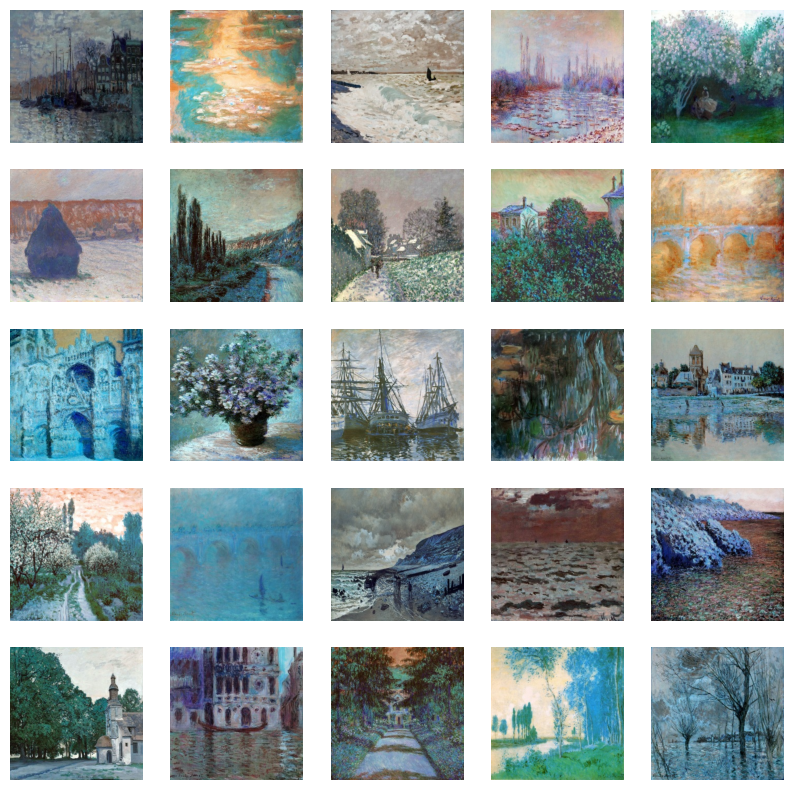

In [14]:
visualize_images(sample_monet)

# Utilities

In [15]:
def zip_images(directory, zip_file_name):
    """
    Given a directory containing image files and a name for a zip file,
    creates a zip file containing all the images in the directory.

    Args:
        directory (str): Path to directory containing image files
        zip_file_name (str): Name for the zip file to be created

    Returns:
        None
    """

    # Create a list of all the image files in the directory
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')]

    # Create a new zip file
    with zipfile.ZipFile(zip_file_name, 'w') as zip_file:
        # Add each image file to the zip file
        for image_file in image_files:
            zip_file.write(image_file, os.path.basename(image_file))

In [16]:
# Display a single image using the epoch number
def display_image(directory, epoch_no):
    return PIL.Image.open(os.path.join(directory, 'image_at_epoch_{:04d}.png'.format(epoch_no)))

In [17]:
def save_batch(directory, batch_predictions):
    for i, image in enumerate(batch_predictions):
    # Create a new figure and axis for each image
        fig, ax = plt.subplots()
        # Display the image on the axis
        ax.imshow(batch_predictions[i, :, :, :])
        plt.axis('off')
        plt.savefig(os.path.join(directory, f'image_{i}.png'), bbox_inches='tight', pad_inches=0)
        # Close the figure to free up memory
        plt.close(fig)

In [18]:
def save_single_image(directory, first_image, epoch):
    image = 0.5 * first_image + 0.5
    plt.imsave(os.path.join(directory, f"image_at{epoch}.png"), image)

In [19]:
def tf_gif(directory, anim_file):
    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob(os.path.join('/kaggle/working/', directory, 'image*.png'))
        filenames = sorted(filenames)

        for i in range(len(filenames)):
            filename = filenames[i]
            image = imageio.imread(filename)

            # Filter to reduce size of gif
            if i < 200:
                if i % 3 == 0:
                    writer.append_data(image)
            else:
                if i % 2 == 0:
                    writer.append_data(image)

In [20]:
def embed_gif(directory):
    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.axis("off")

    imgs_gif = []
    for file_name in sorted(glob.glob(os.path.join('/kaggle/working/', directory, 'image*.png'))):
        #epoch_imgs = plt.imshow(plt.imread(file_name), animated=True)
        imgs_gif.append([plt.imshow(plt.imread(file_name), animated=True)])

    return animation.ArtistAnimation(fig, imgs_gif, interval=250, repeat_delay=250, blit=True)

In [21]:
def plot_loss_training(epochs, mean_loss, title):
    plt.plot(epochs, mean_loss, label='Average loss per epoch', linestyle='--', color='red')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Average Loss per Epoch', fontsize=14)
    plt.grid()
    plt.xlim(0, max(epochs)+1)
    plt.ylim(0, max(mean_loss)+0.5)
    plt.legend()
    plt.savefig(title)
    plt.show()

# Generator Models

In [22]:
def create_generator():
    model = Sequential(name="Generator")

    # Hidden Layer 1: Start with 16 x 16 image
    n_nodes = 16 * 16 * 512 # number of nodes in the first hidden layer
    model.add(Dense(n_nodes, input_shape=(100,), name='Generator-Hidden-Layer-1'))
    model.add(Reshape((16, 16, 512), name='Generator-Hidden-Layer-Reshape-1'))

    # Hidden Layer 2: Upsample to 32 x 32
    model.add(Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-2'))
    model.add(LeakyReLU(alpha=0.2))

    # Hidden Layer 3: Upsample to 64 x 64
    model.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-3'))
    model.add(LeakyReLU(alpha=0.2))

    # Hidden Layer 4: Upsample to 128 x 128
    model.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-4'))
    model.add(LeakyReLU(alpha=0.2))

    # Hidden Layer 5: Upsample to 256 x 256
    model.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-5'))
    model.add(LeakyReLU(alpha=0.2))

    # Output Layer: we use 3 filters because we have 3 channels for a color image.
    model.add(Conv2DTranspose(3, kernel_size=(3, 3), activation='tanh', strides=(1, 1), padding='same', name='Generator-Output-Layer'))

    return model

In [23]:
# Use the noise vector to create an image. The generator is still untrained here!
with strategy.scope():
    generator = create_generator()

# Show model summary
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-Hidden-Layer-1 (  (None, 131072)            13238272  
 Dense)                                                          
                                                                 
 Generator-Hidden-Layer-Res  (None, 16, 16, 512)       0         
 hape-1 (Reshape)                                                
                                                                 
 Generator-Hidden-Layer-2 (  (None, 32, 32, 256)       1179904   
 Conv2DTranspose)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 256)       0         
                                                                 
 Generator-Hidden-Layer-3 (  (None, 64, 64, 128)       295040    
 Conv2DTranspose)                                        

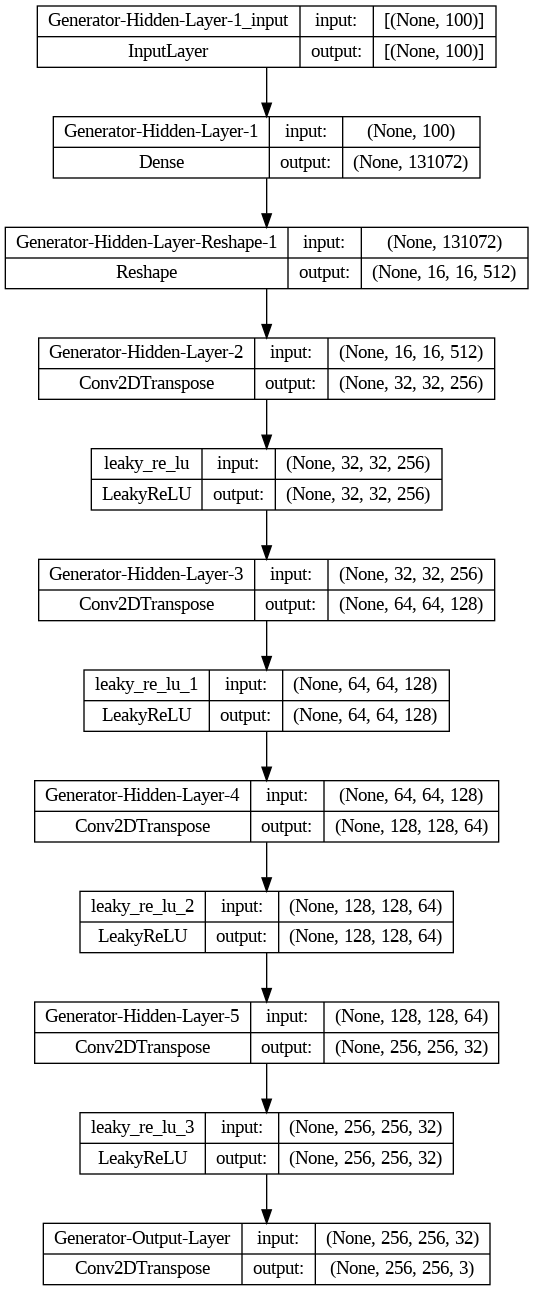

In [24]:
from keras.utils import plot_model

# Visualisasikan arsitektur model
plot_model(generator, show_shapes=True) # to_file='model.png' params for saving

In [25]:
# !pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 6.8 MB/s eta 0:00:00


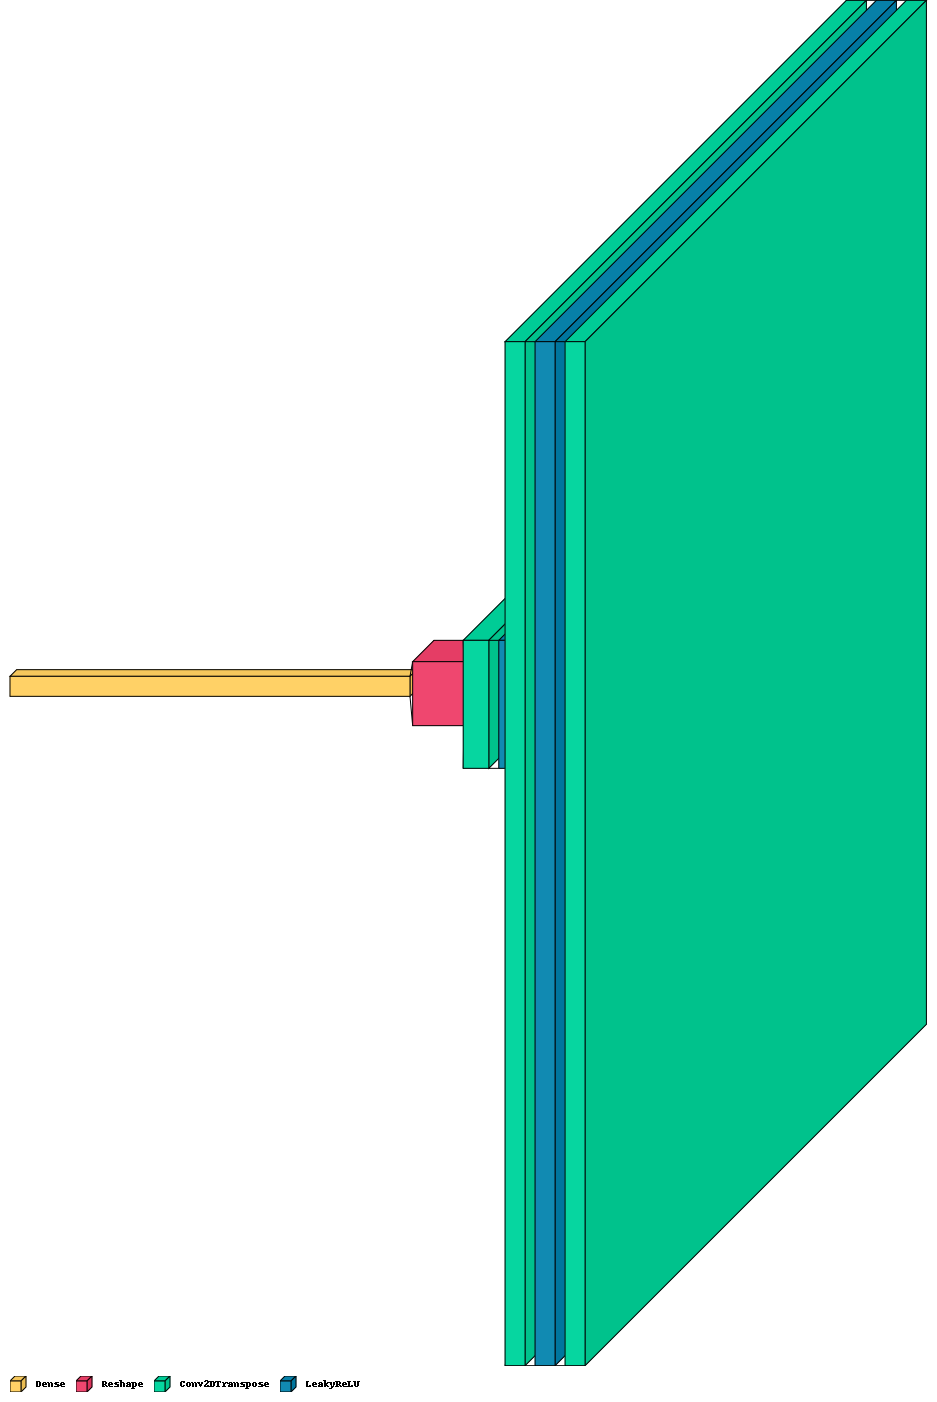

In [26]:
import visualkeras
visualkeras.layered_view(generator, legend=True)

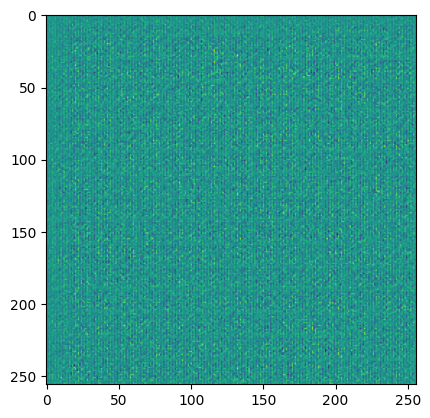

In [28]:
# create vector of random noise to pass through the generator to see what the output is without the network having been trained
noise = tf.random.normal([1, 100])
with strategy.scope():
    generated_image = generator(noise, training=False)

plt.imshow(generated_image[0,:,:,0])

# Discriminator Models

In [29]:
# create a function to build the discriminator model
def create_discriminator():
    model = Sequential(name="Discriminator") # Model

    # Hidden Layer 1
    model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(2, 2), padding='same', input_shape=[256, 256, 3], name='Discriminator-Hidden-Layer-1'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1'))

    # Hidden Layer 2
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-2'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2'))

    # Hidden Layer 3
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-3'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3'))

    # Hidden Layer 4
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-4'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-4'))

    # Hidden Layer 5
    model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-5'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-5'))

    # Flatten and Output Layers
    model.add(Flatten(name='Discriminator-Flatten-Layer')) # Flatten the shape
    model.add(Dropout(0.3, name='Discriminator-Flatten-Layer-Dropout')) # Randomly drop some connections for better generalization
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) # Output Layer

    return model

In [30]:
# Use the noise vector to create an image. The generator is still untrained here!
with strategy.scope():
    discriminator = create_discriminator()

# Show model summary
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator-Hidden-Layer  (None, 128, 128, 32)      896       
 -1 (Conv2D)                                                     
                                                                 
 Discriminator-Hidden-Layer  (None, 128, 128, 32)      0         
 -Activation-1 (LeakyReLU)                                       
                                                                 
 Discriminator-Hidden-Layer  (None, 64, 64, 64)        18496     
 -2 (Conv2D)                                                     
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 Discriminator-Hidden-Layer  (None, 64, 64, 64)      

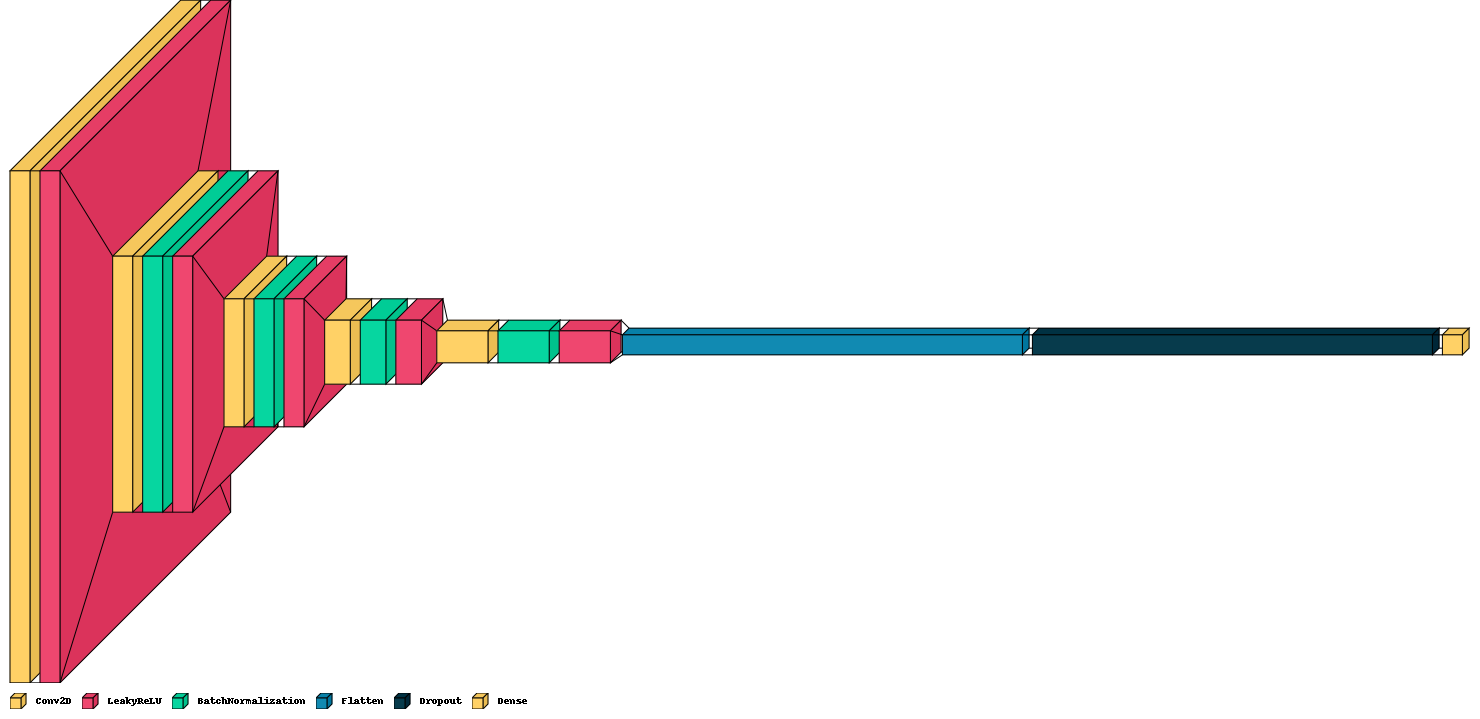

In [31]:
visualkeras.layered_view(discriminator, legend=True)

# Simply Random Testing

In [32]:
# Use the discriminator to classify the image above (1 for real and 0 for fake)
with strategy.scope():
    decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49998617]], shape=(1, 1), dtype=float32)


# Loss Functions & Optimizers

In [33]:
# create loss function for the generator
with strategy.scope():
    def generator_loss(fake_output):
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
        return cross_entropy(tf.ones_like(fake_output), fake_output)

    # create loss function for the discriminator
    def discriminator_loss(real_output, fake_output):
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

In [34]:
# Create two separate optimizers for the generator and discriminator
with strategy.scope():
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Training Loop

In [35]:
# Set the hyperparameters to be used for training
EPOCHS = 100
BATCH_SIZE = 32
noise_dim = 100
shape_dim = [256,256,3]
examples_to_generate = 25
seed = tf.random.normal([examples_to_generate, noise_dim])

In [47]:
class DCGAN_model:
    def __init__(self, noise_dim, seed, EPOCHS, BATCH_SIZE, generator, discriminator, dataset, num_model):
        self.noise_dim = noise_dim
        self.EPOCHS = EPOCHS
        self.BATCH_SIZE = BATCH_SIZE

        self.generator = generator
        #self.discriminator = discriminator2
        self.dataset = dataset
        self.num = num_model
        self.seed = seed

    @tf.function
    def train(self, images):

    # Create random noise vector
        noise = tf.random.normal([images.shape[0], noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # generate images use random noise vector
            generated_images = self.generator(noise, training=True)

            # use discriminator to evaluate the real and fake images
            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)

            # compute generator loss and discriminator loss
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

            # Compute gradients
            gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            # Update optimizers
            generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        return (gen_loss + disc_loss) * 0.5

    @tf.function
    def distributed_train(self, images):
        per_replica_losses = strategy.run(self.train, args=(images,))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)

    def generate_images(self):
        predictions = self.generator.predict(self.seed)
        return predictions

    def save_images(self, directory, epoch, images):
        gen_imgs = 0.5 * images + 0.5

        fig = plt.figure(figsize=(5, 5))

        for i in range(25):
            plt.subplot(5, 5, i+1)
            plt.imshow(gen_imgs[i, :, :, :])
            plt.axis('off')

        plt.savefig(os.path.join(directory, 'image_at_epoch_{:04d}.png'.format(epoch)))
        plt.close()

    def plot_images(self, images):
        gen_imgs = 0.5 * images + 0.5

        fig = plt.figure(figsize=(10, 10))
        for i in range(25):
            plt.subplot(5, 5, i+1)
            plt.imshow(gen_imgs[i, :, :, :])
            plt.axis('off')
        plt.show()

    def train_loop(self):
        e_ls = []
        mean_ls = []

        for epoch in range(self.EPOCHS):
            start = time.time()

            total_loss = 0.0
            num_batches = 0

            for image_batch in self.dataset:
                loss = self.distributed_train(image_batch)
                total_loss += tf.reduce_mean(loss)  # Compute the mean loss accross the tensors
                num_batches += 1

            mean_loss = total_loss / num_batches

            mean_ls.append(mean_loss)
            e_ls.append(epoch+1)

            images = self.generate_images()
            self.save_images(dataPath + '/result' + '/grid_' + self.num, epoch+1, images)
            save_single_image(dataPath + '/result' + '/single_' + self.num, images[0], epoch+1)

            if (epoch+1) % 20 == 0:
                print ('Time for epoch {} is {} sec, mean loss is {}'.format(epoch + 1, time.time()-start, mean_loss))
                self.plot_images(images)

        table = pd.DataFrame({"Epoch": e_ls, "Mean Loss": np.array(mean_ls)})

        return table, e_ls, mean_ls

In [48]:
# train, visualize and print out the result for DCGAN model
gan1 = DCGAN_model(noise_dim, seed, EPOCHS, BATCH_SIZE, generator, discriminator, monet, '1')

In [49]:
table, ep_ls, mean_ls = gan1.train_loop()

Output hidden; open in https://colab.research.google.com to view.

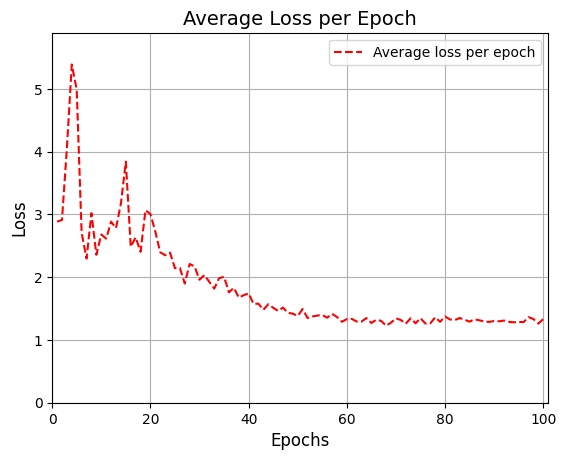

In [50]:
# Plot the losses
plot_loss_training(ep_ls, mean_ls, 'avg_loss_per_epoch')

# Training Gif

In [58]:
tf_gif(dataPath + '/result' + '/single_1', 'single_1.gif')
tf_gif(dataPath + '/result' + '/grid_1', "dcgan_1.gif")

In [61]:
for folder in ['/single', '/grid']:
    zip_images(dataPath + '/result' +  folder + '_1', dataPath + '/result' + folder + '_1.zip')

# DCGAN [5x5 2x2]

In [62]:
def create_generator():
    model = Sequential(name="Generator")

    # Hidden Layer 1: Start with 16 x 16 image
    n_nodes = 16 * 16 * 512 # number of nodes in the first hidden layer
    model.add(Dense(n_nodes, input_shape=(100,), name='Generator-Hidden-Layer-1'))
    model.add(Reshape((16, 16, 512), name='Generator-Hidden-Layer-Reshape-1'))

    # Hidden Layer 2: Upsample to 32 x 32
    model.add(Conv2DTranspose(filters=256, kernel_size=(5, 5), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-2'))
    model.add(LeakyReLU(alpha=0.2))

    # Hidden Layer 3: Upsample to 64 x 64
    model.add(Conv2DTranspose(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-3'))
    model.add(LeakyReLU(alpha=0.2))

    # Hidden Layer 4: Upsample to 128 x 128
    model.add(Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-4'))
    model.add(LeakyReLU(alpha=0.2))

    # Hidden Layer 5: Upsample to 256 x 256
    model.add(Conv2DTranspose(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-5'))
    model.add(LeakyReLU(alpha=0.2))

    # Output Layer: we use 3 filters because we have 3 channels for a color image.
    model.add(Conv2DTranspose(3, kernel_size=(5, 5), activation='tanh', strides=(1, 1), padding='same', name='Generator-Output-Layer'))

    return model

In [63]:
# create a function to build the discriminator model
def create_discriminator():
    model = Sequential(name="Discriminator") # Model

    # Hidden Layer 1
    model.add(Conv2D(filters=32, kernel_size=(5,5), strides=(2, 2), padding='same', input_shape=[256, 256, 3], name='Discriminator-Hidden-Layer-1'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1'))

    # Hidden Layer 2
    model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-2'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2'))

    # Hidden Layer 3
    model.add(Conv2D(filters=128, kernel_size=(5,5), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-3'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3'))

    # Hidden Layer 4
    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-4'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-4'))

    # Hidden Layer 5
    model.add(Conv2D(filters=512, kernel_size=(5,5), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-5'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-5'))

    # Flatten and Output Layers
    model.add(Flatten(name='Discriminator-Flatten-Layer')) # Flatten the shape
    model.add(Dropout(0.3, name='Discriminator-Flatten-Layer-Dropout')) # Randomly drop some connections for better generalization
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) # Output Layer

    return model

In [64]:
with strategy.scope():
    generator = create_generator()
    discriminator = create_discriminator()

    def generator_loss(fake_output):
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
        return cross_entropy(tf.ones_like(fake_output), fake_output)

    # create loss function for the discriminator
    def discriminator_loss(real_output, fake_output):
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [65]:
gan2 = DCGAN_model(noise_dim, seed, EPOCHS, BATCH_SIZE, generator, discriminator, monet, '4')

In [ ]:
table_2, ep_ls_2, mean_ls_2 = gan2.train_loop()

Output hidden; open in https://colab.research.google.com to view.